This is a noise-less trajectory, beggining with initial state stationary

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;</style>"))
import os 
os.chdir("..")
%load_ext autoreload
%autoreload 2
from tqdm import tqdm
from numerics.integration.matrices import *
from numerics.utilities.misc import *
import tensorflow as tf
from numerics.machine_learning.models import * 
import matplotlib.pyplot as plt
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


/tmp/ipykernel_9642/3685532613.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2022-05-16 23:10:43.892790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 23:10:43.914604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 23:10:43.914708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
params, exp_path = def_params()
total_time = 2500.
dt = 1e-1
states_si, dys_si = load(itraj=1, exp_path=exp_path, total_time=total_time, dt=dt, ext_signal=1)

times = get_time(total_time,dt).astype(np.float32)
dd = tf.unstack(dys_si.astype(np.float32),axis=1)

tfsignals = tf.stack([times[:-1],dd[0], dd[1]])
tfsignals = tf.transpose(tfsignals)[tf.newaxis]

2022-05-16 23:10:43.943037: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-16 23:10:43.944003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 23:10:43.944136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 23:10:43.944207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
params, exp_path = def_params()

initial_parameters = np.array([1., 2*np.pi/10]).astype(np.float32)
true_parameters = np.array([10., 2*np.pi/10]).astype(np.float32)


A, D , E, B  = genoni_matrices(*params)
xicov, covss = genoni_xi_cov(A,D, E, B ,params, stat=True)

BS = 1#len(tfsignals[0])
batch_shape = [BS, None, 3]
model = Model(params=params, dt=dt, initial_parameters=initial_parameters,
              true_parameters=true_parameters, initial_states = np.zeros((1,5)).astype(np.float32),
              cov_in=covss, batch_size=tuple([None,None,3]))#tuple(batch_shape))
model.recurrent_layer.build(tf.TensorShape(batch_shape))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))

In [4]:
spp = tf.split(tfsignals, 5000, axis=1)

In [5]:
n_epochs = 100

In [6]:
cc = []
for epoch in range(n_epochs):
    model.reset_states()  
    for k in spp:
        bb = model.train_step((k,k))
        cc+=[bb]
    loss =  np.squeeze(bb["LOSS"].numpy())
    print("\r EPOCH {}/{}   loss:{}    params{}    grads{}".format(epoch, n_epochs,loss, np.squeeze(bb["PARAMS"].numpy()), np.squeeze(bb["GRADS"].numpy())),end="")
    if loss<1e-10:
        break

2022-05-16 23:10:48.071485: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 EPOCH 0/100   loss:3.439026841078885e-11    params[9.999991   0.62831855]    grads[-7.056134e-07  0.000000e+00]

In [7]:
np.zeros((1,6))

array([[0., 0., 0., 0., 0., 0.]])

[]

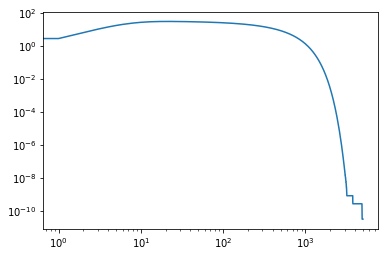

In [8]:
plt.plot(np.squeeze([cc[k]["LOSS"] for k in range(len(cc))]))
plt.loglog()

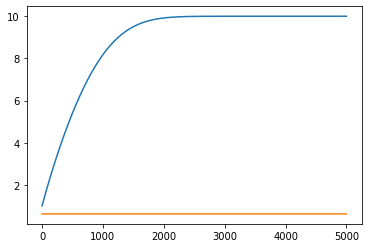

In [9]:
plt.plot(np.squeeze([cc[k]["PARAMS"] for k in range(len(cc))]))

In [14]:
model.recurrent_layer.states

[<tf.Variable 'Variable:0' shape=(1, 5) dtype=float32, numpy=array([[19.99998, 19.99998,  0.     ,  0.     ,  0.     ]], dtype=float32)>]

In [18]:
preds = model.predict(tfsignals)

In [17]:
model.reset_states()

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=array([[0., 0., 0., 0., 0.]], dtype=float32)>

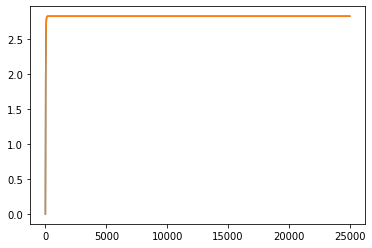

In [26]:
plt.plot(np.squeeze(preds)[:,0])
plt.plot(tfsignals[0][:,1])